# GeoLife Project
## Chapter 1 - Download files
1. Import libraries.
2. Mount google drive.
3. Created function for download zip-file.
4. Unzip and moved file into google drive

In [ ]:
from google.colab import drive
import requests
import re

drive.mount('/content/drive')

def download_file(url="https://download.microsoft.com/"
            "download/F/4/8/F4894AA5-FDBC-481E-9285-D5F8C4C4F039/"
            "Geolife%20Trajectories%201.3.zip"):
    r = requests.get(url, allow_redirects=True)
    filename = "Geolife Trajectories 1.3.zip"

    open(filename, 'wb').write(r.content)

!unzip Geolife\ Trajectories\ 1.3.zip
!rm -r Geolife\ Trajectories\ 1.3.zip
!mv /content/"Geolife Trajectories 1.3" /content/drive/MyDrive/GeoLifeProject

In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget https://downloads.apache.org/spark/spark-3.0.1/spark-3.0.1-bin-hadoop3.2.tgz
!tar -xvf spark-3.0.1-bin-hadoop3.2.tgz
!pip install -q findspark
!rm -r spark-3.0.1-bin-hadoop3.2.tgz

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.1-bin-hadoop3.2"

import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()   

In [27]:
directories_path = "/content/drive/MyDrive/GeoLifeProject/Geolife Trajectories 1.3/Data"

def label_directory(path):
  all_dir = (i for i in os.listdir(path))
  return (i for i in all_dir if 'labels.txt' in os.listdir(path + "/" + i))

In [73]:
list(label_directory(directories_path))[:5]
os.listdir("{0}/{1}/Trajectory/".format(directories_path, "175"))[:5]

['20071019052315.plt',
 '20071019221253.plt',
 '20071021072153.plt',
 '20071022014704.plt']

In [124]:
from pyspark.sql.types import *
from pyspark.sql.functions import *

def labels(path_to_df):
  schema = StructType(
    [StructField("Start Time", StringType(), True),
    StructField("End Time", StringType(), True),
    StructField("Transportation Mode", StringType(), True)]
  )
  
  df = spark.read.format("txt") \
  .option("inferSchema", "false") \
  .option("header", "true") \
  .option("sep", "	") \
  .schema(schema) \
  .csv(path_to_df + "labels.txt") \
  .select(
    regexp_replace("Start Time", '/', '-').alias("Start_time"),
    regexp_replace("End Time", '/', '-').alias("End_time"),
    "Transportation Mode"
  ) \
  .withColumn('Start_datetime', unix_timestamp("Start_time", "yyyy-MM-dd HH:mm:ss")) \
  .withColumn("End_datetime", unix_timestamp("End_time", "yyyy-MM-dd HH:mm:ss"))

  return df


In [123]:
def gps(path_to_df):
  schema = StructType(
    [StructField("latitude", DoubleType(), False),
    StructField("longtitude", DoubleType(), False),
    StructField("zero", IntegerType(), False),
    StructField("altitude", DoubleType(), False),
    StructField("number_days", DoubleType(), False),
    StructField("date", StringType(), False),
    StructField("time", StringType(), False)]
  )
  
  df = spark.read.format("plt") \
   .option('mode','DROPMALFORMED') \
  .option("inferSchema", "false") \
  .option("header", "false") \
  .option("sep", ",") \
  .schema(schema) \
  .csv(path_to_df + "Trajectory/*.plt")\
  .na.drop() \
   .select("latitude",
                 "longtitude",
                 "zero",
                 "altitude",
                 concat_ws(" ","date", "time" ).alias("date_time"),
                 unix_timestamp(concat_ws(" ","date", "time" ), "yyyy-MM-dd HH:mm:ss").alias("timestamp"))
  # .na\
  # .drop()\
  # .select(udf_add_user(int(number_of_directory[:-1]))(col("zero")).alias("id_user"),
  #               "latitude",
  #                "longtitude",
  #                "zero",
  #                "altitude",
  #         "date_time",
  #        "timestamp",
  #         udf_add_transport(txt)(col("timestamp")).alias("transport"),
  #        udf_get_data_start_end(txt)(col("timestamp")).alias("start_end")
  #        )
  
  return df

In [195]:
df1 = labels("{0}/{1}/".format(directories_path, "010"))

In [196]:
df2 = gps("{0}/{1}/".format(directories_path, "010"))

In [197]:
df_join = df2.join(df1)\
.filter((df2.timestamp >= df1.Start_datetime)&(df2.timestamp <= df1.End_datetime) )\
#.filter()\
#.select(["timestamp", "latitude", "longtitude", "altitude", "Transportation Mode", "date_time"])


In [198]:
df_join.printSchema()

root
 |-- latitude: double (nullable = true)
 |-- longtitude: double (nullable = true)
 |-- zero: integer (nullable = true)
 |-- altitude: double (nullable = true)
 |-- date_time: string (nullable = false)
 |-- timestamp: long (nullable = true)
 |-- Start_time: string (nullable = true)
 |-- End_time: string (nullable = true)
 |-- Transportation Mode: string (nullable = true)
 |-- Start_datetime: long (nullable = true)
 |-- End_datetime: long (nullable = true)



+--------+----------+----+--------+---------+---------+----------+--------+-------------------+--------------+------------+
|latitude|longtitude|zero|altitude|date_time|timestamp|Start_time|End_time|Transportation Mode|Start_datetime|End_datetime|
+--------+----------+----+--------+---------+---------+----------+--------+-------------------+--------------+------------+
+--------+----------+----+--------+---------+---------+----------+--------+-------------------+--------------+------------+



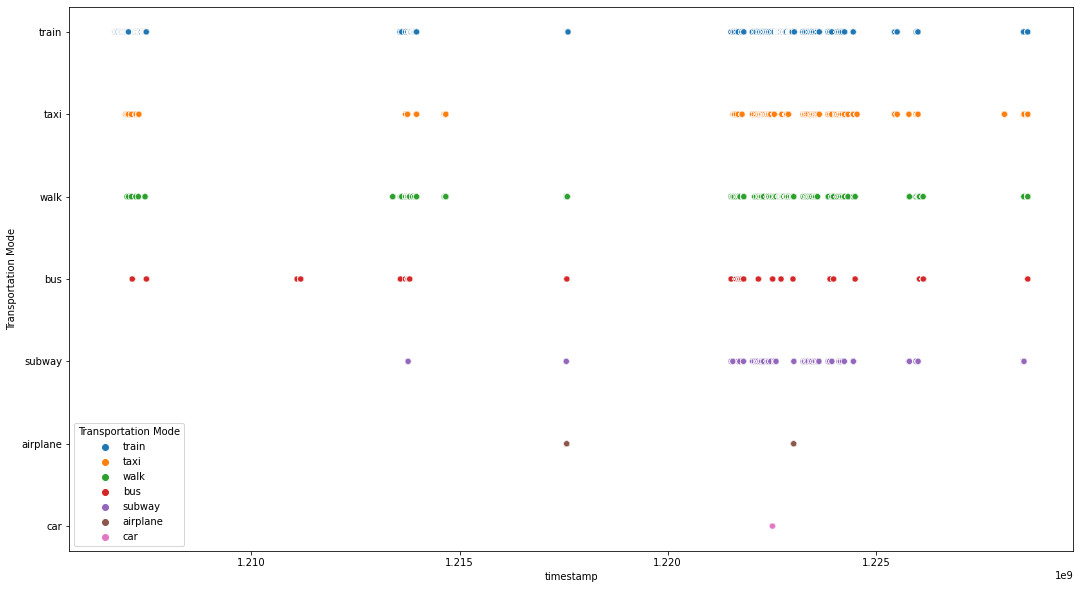

In [200]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

plt.figure(figsize=(18, 10))
sns.scatterplot(x='timestamp', y="Transportation Mode", hue="Transportation Mode",
             data=df_join.orderBy("timestamp").toPandas()
)
plt.show()

In [201]:
df_join.orderBy("timestamp")\
             .groupBy("Transportation Mode")\
      .agg(count("latitude").alias("frequity")).toPandas().head()

,Transportation Mode,frequity
0,bus,35190
1,airplane,1325
2,train,380935
3,taxi,56827
4,walk,37106
